# Sistem Rekomendasi Film Menggunakan Content-Based Filtering dan Collaborative Filtering (SVD)


## Project Overview
### Latar Belakang Proyek

Seiring dengan meningkatnya jumlah film dan serial yang tersedia secara daring, pengguna sering kali kesulitan dalam memilih tontonan yang sesuai dengan preferensi mereka. Untuk itu, sistem rekomendasi menjadi alat yang sangat penting dalam membantu pengguna menemukan konten yang relevan dengan cepat dan efisien. Platform besar seperti Netflix, Amazon Prime, dan Disney+ telah memanfaatkan sistem rekomendasi untuk meningkatkan pengalaman pengguna serta keterlibatan pelanggan.

Namun, pengembangan sistem rekomendasi memiliki tantangan tersendiri, terutama dalam menghadapi masalah **cold start**, yaitu kondisi ketika pengguna baru belum memiliki cukup riwayat interaksi untuk dijadikan dasar rekomendasi. Oleh karena itu, perlu dikembangkan pendekatan yang mampu memberikan rekomendasi berkualitas baik kepada pengguna aktif maupun pengguna baru.

### Tujuan Proyek

Proyek ini bertujuan untuk mengembangkan sistem rekomendasi film yang dapat memberikan **Top-N rekomendasi** berdasarkan dua pendekatan berbeda:

1. **Content-Based Filtering**: Menggunakan informasi deskriptif seperti genre dan sinopsis film untuk merekomendasikan film yang mirip dengan yang pernah disukai pengguna.
2. **Collaborative Filtering (SVD)**: Menggunakan teknik matriks faktorisasi dari pustaka `Surprise` untuk memprediksi rating dan memberikan rekomendasi berdasarkan pola interaksi pengguna lain yang serupa.

Selain membangun model, proyek ini juga bertujuan untuk **mengevaluasi dan membandingkan kedua pendekatan** berdasarkan metrik tertentu seperti akurasi prediksi dan relevansi rekomendasi.

### Pentingnya Proyek Ini

Sistem rekomendasi memiliki peran strategis dalam banyak industri, tidak hanya di bidang hiburan. Pemahaman terhadap metode rekomendasi, serta tantangan-tantangan seperti cold start, sangat penting untuk mengembangkan sistem yang adaptif dan efektif dalam berbagai konteks aplikasi digital.

Proyek ini juga memberikan wawasan tentang efektivitas dua pendekatan populer dalam dunia sistem rekomendasi dan bagaimana keduanya dapat digunakan secara komplementer.

### Referensi dan Riset Terkait

- **Content-Based Filtering**:
  Lops, P., De Gemmis, M., & Semeraro, G. (2011). Content-based Recommender Systems: State of the Art and Trends. In *Recommender Systems Handbook*.
  [Link PDF Chapter](https://link.springer.com/chapter/10.1007/978-0-387-85820-3_3)

- **Collaborative Filtering dengan SVD**:
  Koren, Y., Bell, R., & Volinsky, C. (2009). Matrix Factorization Techniques for Recommender Systems. *IEEE Computer*, 42(8), 30–37.  
  [https://ieeexplore.ieee.org/document/5197422](https://ieeexplore.ieee.org/document/5197422)

- **Cold Start Problem**:
  Schein, A. I., Popescul, A., Ungar, L. H., & Pennock, D. M. (2002). Methods and Metrics for Cold-Start Recommendations. In *Proceedings of the 25th Annual International ACM SIGIR Conference on Research and Development in Information Retrieval*.
  [https://dl.acm.org/doi/10.1145/564376.564421](https://dl.acm.org/doi/10.1145/564376.564421)

### Kesimpulan

Proyek ini akan menghasilkan sistem rekomendasi film yang mampu memberikan saran yang personal dan relevan kepada pengguna, baik yang sudah memiliki riwayat interaksi maupun pengguna baru. Dengan membandingkan dua pendekatan utama, proyek ini juga memberikan kontribusi praktis terhadap pengembangan sistem rekomendasi yang lebih adaptif dan responsif.

---


## Business Understanding

### Problem Statements
- Bagaimana cara menyarankan film yang relevan kepada pengguna berdasarkan preferensi sebelumnya?
- Bagaimana mengatasi masalah cold start atau pengguna baru dengan sedikit data?

### Goals
- Mengembangkan sistem rekomendasi film yang mampu memberikan Top-N rekomendasi bagi pengguna.
- Menggunakan dua pendekatan berbeda untuk mengevaluasi dan membandingkan hasilnya.

### Solution Approach
- **Content-Based Filtering:** Menggunakan deskripsi film dan genre untuk menyarankan item serupa.
- **Collaborative Filtering:** Menggunakan teknik SVD dari pustaka Surprise untuk memprediksi rating dan memberikan rekomendasi.

# Import Library

In [1]:
!pip install "numpy<2"

In [2]:
!pip install scikit-surprise

In [74]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Feature Engineering & Similarity (Content-Based Filtering) =====
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ===== Surprise Library (Collaborative Filtering - SVD) =====
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split

# Data Understanding

Dataset MovieLens 100k berisi 100.000 rating yang diberikan oleh 943 pengguna terhadap 1682 film. Terdapat tiga file utama:
- `u.data`: Data rating (user_id, item_id, rating, timestamp)
- `u.item`: Metadata film (item_id, title, genre, dsb)
- `u.user`: Informasi pengguna

Link sumber data: [https://grouplens.org/datasets/movielens/100k](https://grouplens.org/datasets/movielens/100k)

### Data yang Digunakan

Pada proyek sistem rekomendasi ini, beberapa file dataset dari **MovieLens 100k** akan digunakan. Masing-masing file memuat informasi penting yang dibutuhkan dalam proses rekomendasi, baik berbasis konten (*Content-Based Filtering*) maupun kolaboratif (*Collaborative Filtering*).

#### 1. Users
Data pengguna memuat informasi demografis dasar mengenai setiap pengguna yang memberikan rating:
- `user_id`: ID unik pengguna  
- `age`: Usia pengguna  
- `sex`: Jenis kelamin pengguna  
- `occupation`: Pekerjaan pengguna  
- `zip_code`: Kode pos tempat tinggal pengguna  

#### 2. Genres
File ini memuat daftar genre yang tersedia:
- `genre_id`: ID genre  
- `genre_name`: Nama genre (misalnya: Action, Comedy, Drama)  

#### 3. Movies
Data film memuat metadata tentang film yang tersedia dalam sistem:
- `movie_id`: ID unik film  
- `movie_title`: Judul film  
- `release_date`: Tanggal rilis film  
- `video_release_date`: Tanggal rilis video (jika tersedia)  
- `IMDb_URL`: Link ke halaman IMDb film  
- **Genre Encoding (One-hot)**: 19 kolom genre yang menunjukkan apakah film termasuk dalam genre tertentu (bernilai 1 jika ya, 0 jika tidak)  

#### 4. Ratings
Data interaksi antara pengguna dan film dalam bentuk rating:
- `user_id`: ID pengguna yang memberikan rating  
- `movie_id`: ID film yang diberikan rating  
- `rating`: Nilai rating (skala 1–5)  
- `unix_timestamp`: Waktu saat rating diberikan (dalam format UNIX timestamp)  


### Data Loading

Pada tahap ini, kita memuat dataset yang akan digunakan untuk sistem rekomendasi.

#### Users

Memuat data Users

In [5]:
# Menentukan nama kolom pada file user
user_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

# Membaca file u.user
users = pd.read_csv('ml-100k/ml-100k/u.user',
                    sep='|',
                    header=None,
                    names=user_cols,
                    engine='python',
                    encoding='latin-1')

# Menampilkan 5 baris pertama
users.head()


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [6]:
# Informasi struktur data pengguna
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   sex         943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


Hasil menunjukkan data `users` memiliki 5 kolom dan total 943 data dengan tidak ada yang kosong (`null`).

In [ ]:
# Menampilkan jumlah pengguna

n_users = users.shape[0]
print(f'Jumlah pengguna: {n_users}')

Jumlah pengguna: 943


#### Genres

Memuat data genres

In [10]:
# Menentukan nama kolom untuk file genre
genre_cols = ['genre_name', 'genre_id']

# Menentukan nama kolom untuk file genre
genre_cols = ['genre_name', 'genre_id']

# Membaca file u.genre
genres = pd.read_csv('ml-100k/ml-100k/u.genre',
                     sep='|',
                     header=None,
                     names=genre_cols,
                     engine='python',
                     encoding='latin-1')

# Menampilkan beberapa data genre pertama
genres.head()
genre_cols = ['genre_name', 'genre_id']

# Membaca file u.genre
genres = pd.read_csv('ml-100k/ml-100k/u.genre',
                     sep='|',
                     header=None,
                     names=genre_cols,
                     engine='python',
                     encoding='latin-1')

# Menampilkan beberapa data genre pertama
genres.head()
# Menampilkan beberapa data genre pertama
genres.head()

,genre_name,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [11]:
# Informasi struktur genre
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   genre_name  19 non-null     object
 1   genre_id    19 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 436.0+ bytes


In [12]:
# Menampilkan jumlah genre
n_genres = genres.shape[0]
print(f'Jumlah genre: {n_genres}')

Jumlah genre: 19


#### Movies

Memuat data Movies

In [13]:
# Menentukan nama kolom untuk data film
movie_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']
movie_cols += genres['genre_name'].tolist()  # Menambahkan kolom genre dari file u.genre

# Membaca file u.item
movies = pd.read_csv('ml-100k/ml-100k/u.item',
                     sep='|',
                     header=None,
                     names=movie_cols,
                     engine='python',
                     encoding='latin-1')

# Menampilkan 5 data movie pertama
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
# Menampilkan 5 data movie terakhir
movies.tail()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children's          1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

Hasil menunjukkan data `movies` memiliki 24 kolom dan total 1682 data dengan tidak ada yang kosong (`null`).

In [16]:
# Menampilkan jumlah movie

n_movies = movies.shape[0]
print(f'Jumlah movies: {n_movies}')

Jumlah movies: 1682


#### Ratings

Memuat data Ratings

In [17]:
# Menentukan nama kolom
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

# Membaca data pelatihan dan pengujian
ratings_base = pd.read_csv('ml-100k/ml-100k/ua.base',
                           sep='\t',
                           header=None,
                           names=rating_cols,
                           engine='python',
                           encoding='latin-1')

ratings_test = pd.read_csv('ml-100k/ml-100k/ua.test',
                           sep='\t',
                           header=None,
                           names=rating_cols,
                           engine='python',
                           encoding='latin-1')

In [18]:
# Menampilkan beberapa data awal
ratings_base.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [19]:
# Informasi data train
ratings_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90570 entries, 0 to 90569
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         90570 non-null  int64
 1   movie_id        90570 non-null  int64
 2   rating          90570 non-null  int64
 3   unix_timestamp  90570 non-null  int64
dtypes: int64(4)
memory usage: 2.8 MB


In [20]:
# Informasi data test
ratings_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9430 entries, 0 to 9429
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         9430 non-null   int64
 1   movie_id        9430 non-null   int64
 2   rating          9430 non-null   int64
 3   unix_timestamp  9430 non-null   int64
dtypes: int64(4)
memory usage: 294.8 KB


Hasil menunjukkan data `ratings_base` dan `ratings_test` memiliki 4 kolom dan total 90570 data pada `ratings_base` dan 9430 data pada `ratings_test` dengan tidak ada yang kosong (`null`).

In [21]:
n_train = ratings_base.values
n_test = ratings_test.values

print(f'Jumlah rating pada data pelatihan (train): {n_train.shape[0]}')
print(f'Jumlah rating pada data pengujian (test): {n_test.shape[0]}')

Jumlah rating pada data pelatihan (train): 90570
Jumlah rating pada data pengujian (test): 9430


### EDA

EDA atau Exploratory Data Analysis adalah proses awal dalam analisis data yang dilakukan untuk memahami karakteristik, pola, dan struktur dataset sebelum melakukan analisis lebih lanjut atau pemodelan.

#### Users

In [22]:
# Menggabungkan peringkat dari kumpulan data dasar dan uji
all_ratings = pd.concat([ratings_base, ratings_test])

In [23]:
# Menghitung rating per pengguna
ratings_per_user = all_ratings.groupby('user_id')['rating'].count()

In [24]:
# Menghitung statistik deskriptif
min_ratings = ratings_per_user.min()
max_ratings = ratings_per_user.max()
mean_ratings = ratings_per_user.mean()
median_ratings = ratings_per_user.median()
std_ratings = ratings_per_user.std()
skewness = ratings_per_user.skew()

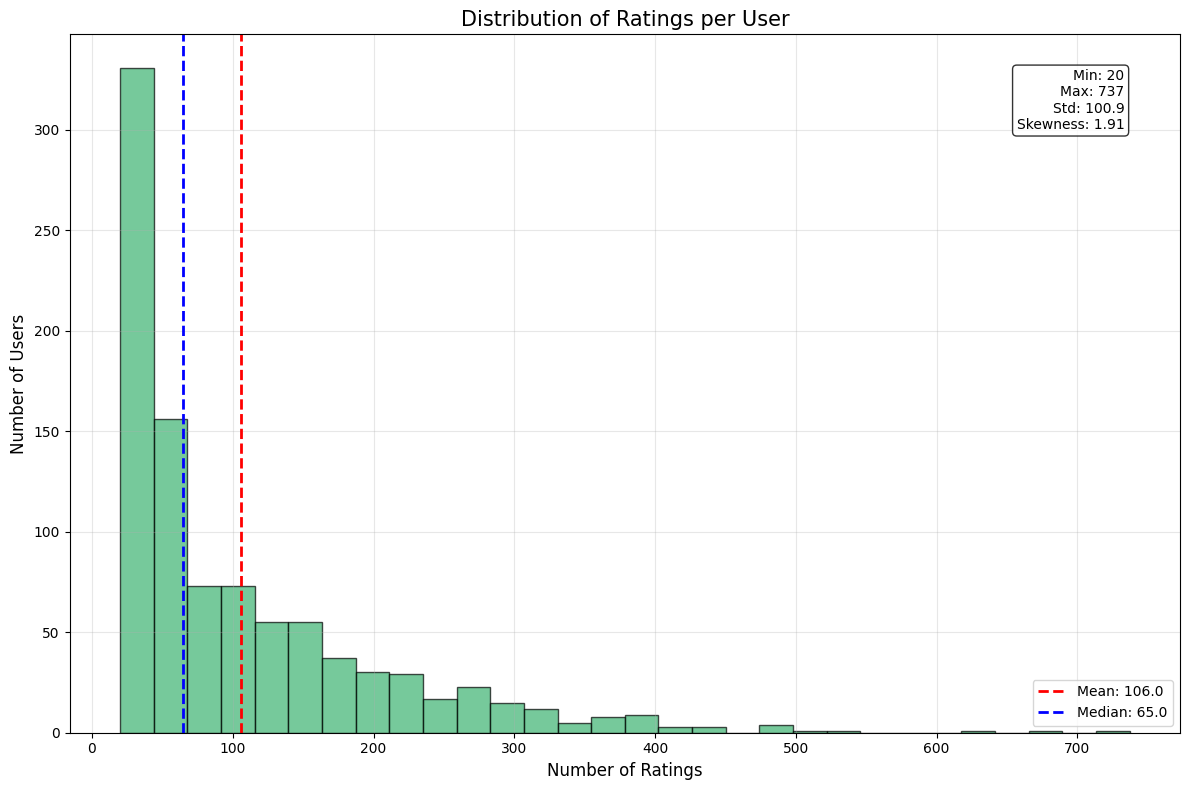

In [25]:
# Visualisasi distribusi jumlah rating per pengguna (Histogram)
plt.figure(figsize=(12, 8))
n, bins, patches = plt.hist(ratings_per_user, bins=30, alpha=0.7, color='mediumseagreen', edgecolor='black')

plt.axvline(mean_ratings, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_ratings:.1f}')
plt.axvline(median_ratings, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_ratings:.1f}')

stats_text = f'Min: {min_ratings}\nMax: {max_ratings}\nStd: {std_ratings:.1f}\nSkewness: {skewness:.2f}'
plt.annotate(stats_text, xy=(0.95, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8),
             ha='right', va='top')

plt.title('Distribution of Ratings per User', fontsize=15)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

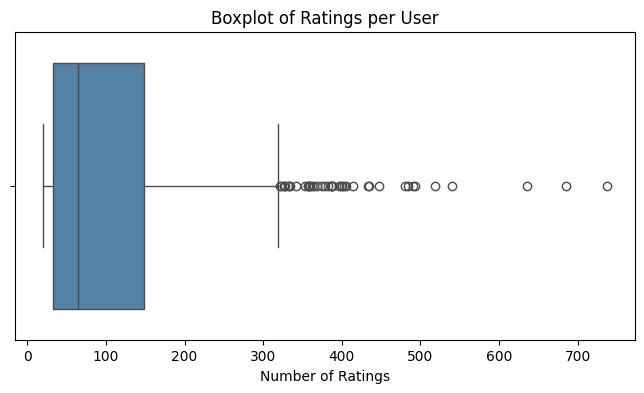

In [26]:
# Visualisasi boxplot untuk melihat outlier
plt.figure(figsize=(8, 4))
sns.boxplot(x=ratings_per_user, color='steelblue')
plt.title('Boxplot of Ratings per User')
plt.xlabel('Number of Ratings')
plt.show()

In [27]:
# Menampilkan informasi pengguna
print(f"Total number of users: {len(ratings_per_user)}")
print(f"Total number of ratings: {len(all_ratings)}")
print(f"Average number of ratings per user: {mean_ratings:.2f}")
print(f"Maximum number of ratings by a user: {max_ratings}")
print(f"Minimum number of ratings by a user: {min_ratings}")
print(f"Skewness of ratings per user: {skewness:.2f}")

Total number of users: 943
Total number of ratings: 100000
Average number of ratings per user: 106.04
Maximum number of ratings by a user: 737
Minimum number of ratings by a user: 20
Skewness of ratings per user: 1.91


- Total pengguna: Ada 943 pengguna yang memberikan rating, ini menunjukkan ukuran komunitas pengguna yang cukup besar.

- Total rating: Terdapat 100,000 rating yang telah diberikan, berarti rata-rata setiap pengguna cukup aktif dalam memberikan feedback.

- Rata-rata rating per pengguna: Setiap pengguna rata-rata memberikan sekitar 106 rating. Ini adalah indikasi bahwa sebagian besar pengguna aktif dan memberi cukup banyak rating.

- Minimum rating per pengguna: Setiap pengguna memberikan minimal 20 rating, artinya data tidak mengandung pengguna yang hanya memberikan sedikit rating, yang bagus untuk kestabilan model rekomendasi.

- Maksimum rating per pengguna: Ada pengguna yang sangat aktif, dengan 737 rating. Ini menunjukkan adanya pengguna power-user yang sangat aktif berinteraksi dengan sistem.

- Skewness sebesar 1.91: Distribusi jumlah rating per pengguna miring ke kanan (positif)

### Genres

In [28]:
# Menghitung jumlah film untuk setiap genre
genre_columns = [col for col in movies.columns if col not in ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']]
genre_counts = {genre: movies[genre].sum() for genre in genre_columns}

In [29]:
# Membuat Series dan mengurutkan dari yang terbanyak
genre_distribution = pd.Series(genre_counts).sort_values(ascending=False)

<ipython-input-30-34856ceae027>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=genre_distribution.values, y=genre_distribution.index, palette='coolwarm')


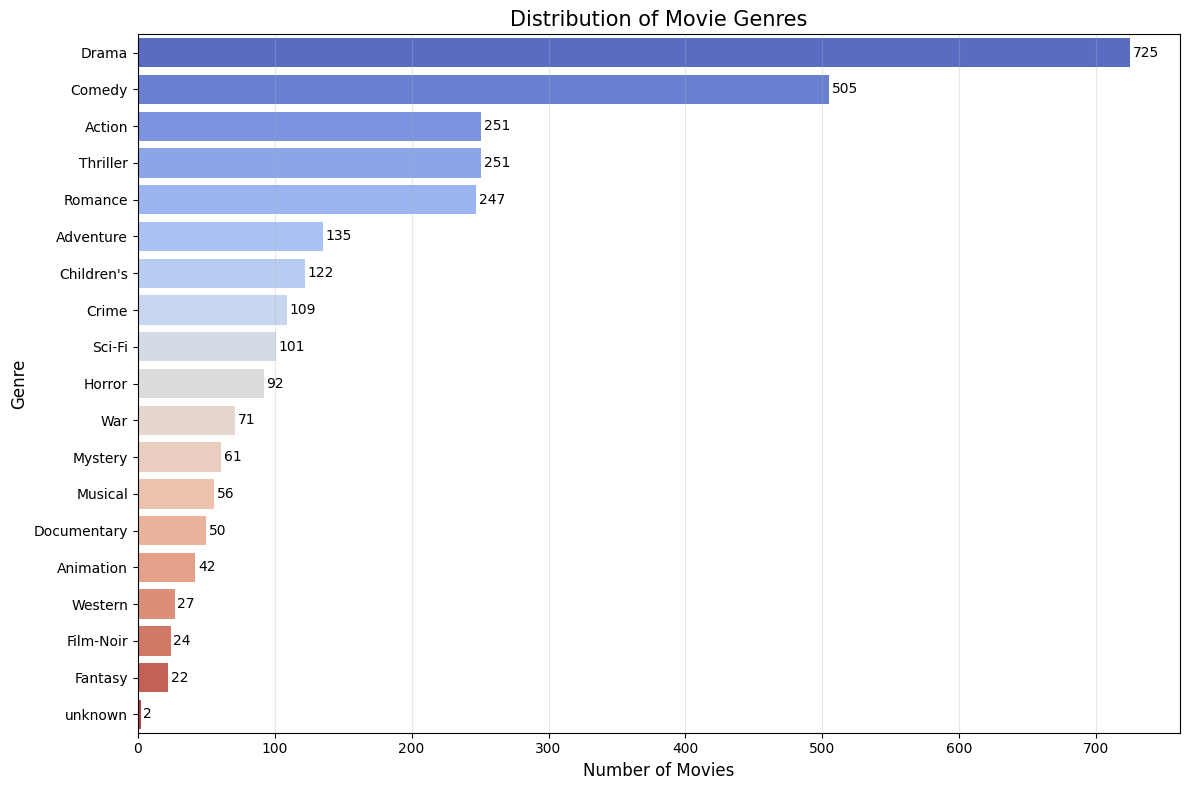

In [30]:
# Visualisasi distribusi genre film dengan palet warna 'coolwarm'
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=genre_distribution.values, y=genre_distribution.index, palette='coolwarm')

# Menambahkan angka jumlah film di ujung bar
for i, v in enumerate(genre_distribution.values):
    ax.text(v + 2, i, f"{int(v)}", va='center')

plt.title('Distribution of Movie Genres', fontsize=15)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
# Menampilkan ringkasan informasi genre
print(f"Total number of genre assignments: {genre_distribution.sum()}")
print(f"Average genres per movie: {genre_distribution.sum() / n_movies:.2f}")
print(f"Most common genre: {genre_distribution.index[0]} ({int(genre_distribution.values[0])} movies)")
print(f"Least common genre: {genre_distribution.index[-1]} ({int(genre_distribution.values[-1])} movies)")

Total number of genre assignments: 2893
Average genres per movie: 1.72
Most common genre: Drama (725 movies)
Least common genre: unknown (2 movies)


- Total genre assignments: Terdapat 2,893 penugasan genre di seluruh film, artinya setiap film bisa punya lebih dari satu genre.

- Rata-rata genre per film: Setiap film memiliki rata-rata 1.72 genre, yang menunjukkan sebagian besar film menggabungkan satu atau dua genre sekaligus.

- Genre paling umum: Genre Drama adalah yang paling banyak muncul dengan 725 film, menunjukkan bahwa drama adalah tema yang sangat populer di dataset ini.

- Genre paling sedikit: Genre unknown hanya muncul pada 2 film, yang menunjukkan data hampir lengkap terkait kategori genre untuk film-film di dataset.

Ditemukan genre "unknown" yang hanya muncul pada 2 film dalam dataset.
Kita cari tahu film apa yang bergenre "unknown" itu.

In [32]:
# Cari film dengan genre 'unknown'
unknown_movies = movies[movies['unknown'] == 1]
print(f"Jumlah film dengan genre 'unknown': {len(unknown_movies)}")

# Kolom genre selain metadata dan 'unknown'
kolom_dikecualikan = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown']
kolom_genre = [col for col in movies.columns if col not in kolom_dikecualikan]

# Cek apakah film 'unknown' juga punya genre lain
punya_genre_lain = unknown_movies[kolom_genre].sum(axis=1) > 0

# Tampilkan detail film dengan genre 'unknown'
print("\nDetail film dengan genre 'unknown':")
print(unknown_movies[['movie_id', 'movie_title', 'release_date']])

# Tampilkan jumlah film yang punya genre lain dan yang hanya 'unknown'
print(f"\nFilm 'unknown' dengan genre lain: {punya_genre_lain.sum()}")
print(f"Film hanya 'unknown': {(~punya_genre_lain).sum()}")

Jumlah film dengan genre 'unknown': 2

Detail film dengan genre 'unknown':
      movie_id          movie_title release_date
266        267              unknown          NaN
1372      1373  Good Morning (1971)   4-Feb-1971

Film 'unknown' dengan genre lain: 0
Film hanya 'unknown': 2


Jumlah film dengan genre 'unknown' hanya 2, yang berarti sangat sedikit dan tidak signifikan dibandingkan total film dalam dataset.

Dari dua film tersebut, ada satu film dengan judul yang memang "unknown" dan satu film lain berjudul "Good Morning (1971)" yang juga dikategorikan sebagai "unknown".

Kedua film ini hanya memiliki genre 'unknown' tanpa genre lain yang menyertainya, sehingga tidak ada film dengan genre 'unknown' yang juga memiliki genre lain.

Karena jumlah dan pengaruhnya yang sangat kecil, genre "unknown" ini dapat dianggap sebagai data outlier atau data yang kurang lengkap.



Melihat hasil tersebut, sangat disarankan untuk menghapus kolom genre "unknown" dari dataset agar data menjadi lebih bersih dan analisis genre menjadi lebih akurat. Penghapusan ini tidak akan banyak mengurangi informasi karena hanya berdampak pada 2 film saja.

In [33]:
# Menghapus film dengan genre 'unknown' yang tidak memiliki genre lain
movie_ids_to_remove = unknown_movies[~punya_genre_lain]['movie_id'].tolist()
movies = movies[~movies['movie_id'].isin(movie_ids_to_remove)]

# Menghapus kolom 'unknown' dari DataFrame movies
if 'unknown' in movies.columns:
    movies = movies.drop('unknown', axis=1)

# Menghapus genre 'unknown' dari daftar genre (genre_columns) jika ada
genre_columns = [col for col in movies.columns if col not in ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']]
if 'unknown' in genre_columns:
    genre_columns.remove('unknown')

# Menghapus genre 'unknown' dari DataFrame genres
if 'genres' in globals():  # Pastikan variabel genres ada
    genres = genres[genres['genre_name'] != 'unknown']

print(f"Menghapus {len(movie_ids_to_remove)} film dengan genre 'unknown' tanpa genre lain.")
print(f"Jumlah film : {movies.shape[0]}")
print(f"Jumlah genre: {len(genres) if 'genres' in globals() else 'DataFrame genres tidak ditemukan'}")


Menghapus 2 film dengan genre 'unknown' tanpa genre lain.
Jumlah film : 1680
Jumlah genre: 18


### Ratings

<ipython-input-34-f94d521d890f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='mako')


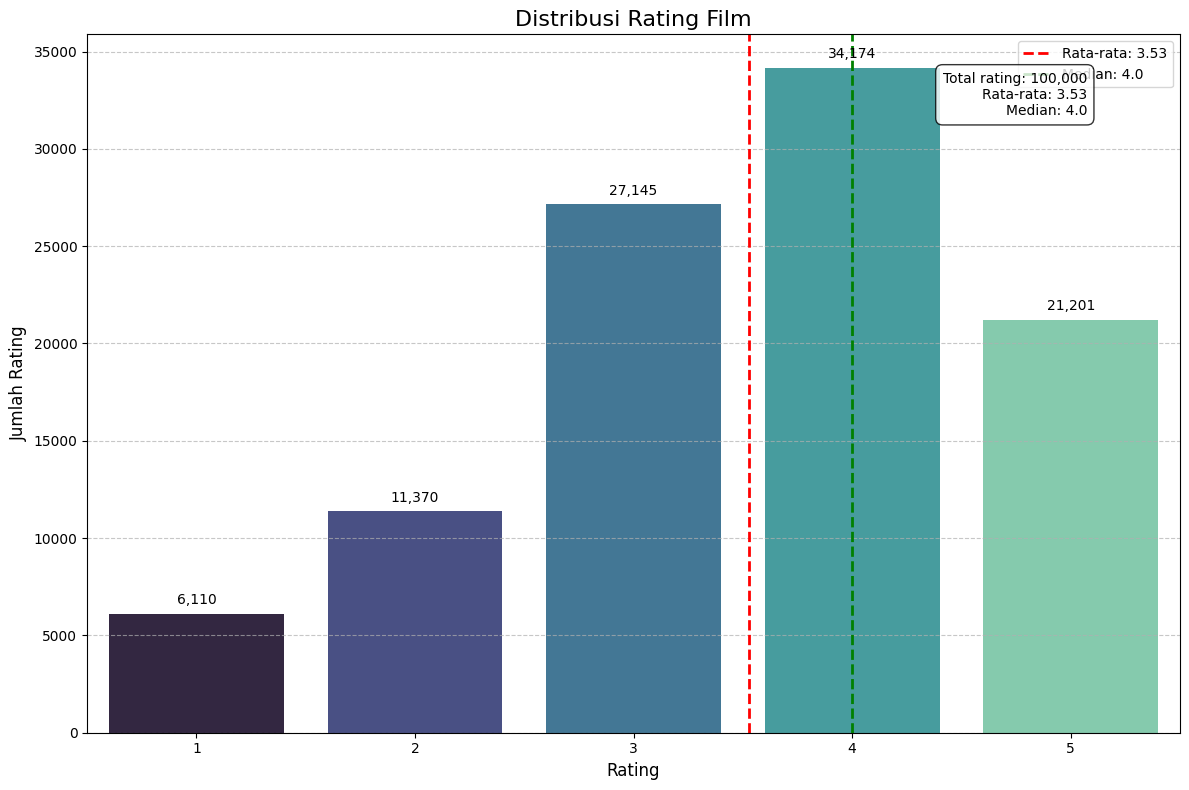

In [34]:
plt.figure(figsize=(12, 8))

# Hitung distribusi jumlah rating untuk setiap skor
rating_counts = all_ratings['rating'].value_counts().sort_index()

# Plot distribusi rating
ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='mako')

# Tambahkan label angka di atas bar
for i, count in enumerate(rating_counts.values):
    ax.text(i, count + 500, f"{count:,}", ha='center', fontsize=10)

# Hitung statistik
mean_rating = all_ratings['rating'].mean()
median_rating = all_ratings['rating'].median()
total_ratings = len(all_ratings)

# Tambahkan garis rata-rata dan median
plt.axvline(x=mean_rating - 1, color='red', linestyle='--', linewidth=2, label=f'Rata-rata: {mean_rating:.2f}')
plt.axvline(x=median_rating - 1, color='green', linestyle='--', linewidth=2, label=f'Median: {median_rating:.1f}')

# Judul dan label
plt.title('Distribusi Rating Film', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Jumlah Rating', fontsize=12)
plt.xticks(ticks=range(5), labels=['1', '2', '3', '4', '5'])

# Tampilkan total statistik di pojok atas
plt.figtext(0.91, 0.85,
            f"Total rating: {total_ratings:,}\nRata-rata: {mean_rating:.2f}\nMedian: {median_rating:.1f}",
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
            horizontalalignment='right')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Distribusi rating menunjukkan kecenderungan pengguna yang lebih sering memberikan penilaian positif (di atas 3). Ini dapat mengindikasikan:

- Film-film dalam dataset cenderung disukai pengguna, atau

- Bias positif dalam sistem rating, di mana pengguna lebih terdorong untuk menilai film yang mereka sukai.

Distribusi ini penting untuk diperhatikan dalam pengembangan sistem rekomendasi, agar model tidak hanya mengandalkan popularitas film dengan rating tinggi, tetapi juga mempertimbangkan keragaman preferensi pengguna.



## Data Preparation

Dalam tahap ini dilakukan beberapa langkah seperti:
- **Merge** data rating dengan metadata film
- **Preprocessing** pada judul/genre
- **TF-IDF vectorization** untuk konten film
- **Mapping** ID pengguna dan film

Langkah ini penting agar data siap digunakan dalam model rekomendasi baik berbasis konten maupun kolaboratif.

#### Content based Filtering

Pada sistem Content-Based Filtering, kita merekomendasikan item (film) berdasarkan kemiripan kontennya — dalam hal ini, genre film. Proses ini menyiapkan data agar bisa diproses menggunakan teknik seperti TF-IDF untuk menghitung kemiripan antar film.

In [35]:
# Persiapan Data untuk Rekomendasi Berbasis Konten
def prepare_content_based_data():
    """
    Menyiapkan data film dengan representasi genre dalam format teks
    untuk digunakan dalam pemodelan berbasis konten (TF-IDF).
    """
    # Salin data film untuk diproses
    movie_features = movies.copy()

    # Daftar semua genre yang tersedia
    genre_columns = [
        'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
    ]

    # Pilih kolom movie_id, movie_title, dan semua genre
    content_df = movie_features[['movie_id', 'movie_title'] + genre_columns].copy()

    # Gabungkan genre yang aktif (bernilai 1) menjadi satu string per film
    content_df['genres'] = content_df[genre_columns].apply(
        lambda row: ' '.join([genre for genre, val in zip(genre_columns, row) if val == 1]),
        axis=1
    )

    # Reset index untuk memastikan struktur data yang bersih
    content_df = content_df.reset_index(drop=True)

    return content_df, genre_columns

In [36]:
# Memanggil fungsi untuk mendapatkan data berbasis konten
content_data, genre_columns = prepare_content_based_data()

# Menampilkan 5 data pertama
content_data.head()

,movie_id,movie_title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genres
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Animation Children's Comedy
1,2,GoldenEye (1995),1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Action Adventure Thriller
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Thriller
3,4,Get Shorty (1995),1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,Action Comedy Drama
4,5,Copycat (1995),0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,Crime Drama Thriller


In [37]:
# Membuat matriks TF-IDF berdasarkan genre film
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(content_data['genres'])

In [38]:
# Menghitung cosine similarity antar film
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [39]:
# Menampilkan contoh matriks TF-IDF dalam bentuk DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=content_data['movie_title']
)

In [40]:
# Menampilkan 5 film dan 10 genre secara acak dari matriks TF-IDF
tfidf_df.sample(5, axis=0).sample(10, axis=1)

,war,musical,thriller,comedy,adventure,noir,sci,mystery,fantasy,romance
movie_title,,,,,,,,,,
Bird of Prey (1996),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ulee's Gold (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kansas City (1996),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
In & Out (1997),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"Next Karate Kid, The (1994)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Collaborative Filtering

Pada tahap ini, data rating disiapkan agar sesuai dengan kebutuhan algoritma Collaborative Filtering, khususnya model SVD dari library Surprise.

In [47]:
# Drop kolom yang tidak dibutuhkan (timestamp)
ratings_cf = all_ratings.drop(columns='unix_timestamp')

# Inisialisasi Reader dengan skala rating (1 sampai 5)
reader = Reader(rating_scale=(1, 5))

# Konversi DataFrame menjadi dataset Surprise
data = Dataset.load_from_df(ratings_cf[['user_id', 'movie_id', 'rating']], reader)

# Bagi data menjadi data latih dan data uji (80% - 20%)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

In [48]:
# Cek apakah ada duplikasi user_id & movie_id
duplicates = ratings_cf.duplicated(subset=['user_id', 'movie_id']).sum()
print(f'Jumlah data duplikat user–movie: {duplicates}')

Jumlah data duplikat user–movie: 0


In [49]:
# Cek apakah ada missing value
missing = ratings_cf.isnull().sum()
print('Jumlah missing value per kolom:')
print(missing)

Jumlah missing value per kolom:
user_id     0
movie_id    0
rating      0
dtype: int64


In [50]:
# Statistik deskriptif nilai rating
print('\nDistribusi rating:')
print(ratings_cf['rating'].value_counts().sort_index())


Distribusi rating:
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64


In [51]:
# Tampilkan 5 data pertama
print('\nContoh data ratings:')
print(ratings_cf.head())


Contoh data ratings:
   user_id  movie_id  rating
0        1         1       5
1        1         2       3
2        1         3       4
3        1         4       3
4        1         5       3


## Modelling

Dua model dibangun untuk sistem rekomendasi:

1. **Content-Based Filtering**
   - Menggunakan TF-IDF untuk representasi fitur genre film.
   - Menghitung cosine similarity antar film.
   - Merekomendasikan film berdasarkan kemiripan konten.

2. **Collaborative Filtering (SVD)**
   - Menggunakan algoritma SVD dari library Surprise.
   - Melatih model pada data training.
   - Memberikan rekomendasi berdasarkan prediksi rating tertinggi.

## Content Based Filtering

### Fungsi Rekomendasi Berdasarkan Judul Film

In [52]:
def recommend(title, cosine_sim=cosine_sim, k=10):
    # Membuat pemetaan judul ke indeks baris
    indices = pd.Series(content_data.index, index=content_data['movie_title']).drop_duplicates()

    try:
        # Ambil indeks film
        idx = indices[title]

        # Dapatkan skor kemiripan dengan semua film lainnya
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:k+1]  # Lewati film itu sendiri

        # Genre film target
        target_genres = set([genre for genre in genre_columns if content_data.iloc[idx][genre] == 1])

        # Siapkan hasil rekomendasi dan perhitungan precision@k
        recommendations = []
        relevant_count = 0

        for i, score in sim_scores:
            movie_genres = set([genre for genre in genre_columns if content_data.iloc[i][genre] == 1])
            is_relevant = len(target_genres.intersection(movie_genres)) > 0
            if is_relevant:
                relevant_count += 1

            main_genre = next(iter(movie_genres)) if movie_genres else "Unknown"

            recommendations.append({
                'movie_id': content_data.iloc[i]['movie_id'],
                'title': content_data.iloc[i]['movie_title'],
                'genre': main_genre,
                'similarity': round(score, 4),
                'is_relevant': is_relevant
            })

        precision_k = relevant_count / k if k > 0 else 0

        return {
            'recommendations': recommendations,
            'precision_at_k': precision_k,
            'k': k,
            'target_genres': target_genres
        }

    except KeyError:
        print(f"Film '{title}' tidak ditemukan dalam dataset.")
        return []
    except Exception as e:
        print(f"Terjadi kesalahan saat merekomendasikan film: {str(e)}")
        return []

### Fungsi Menampilkan Rekomendasi dalam Tabel

In [53]:
def display_recommendations(recommendations_result, title):
    if not isinstance(recommendations_result, dict) or 'recommendations' not in recommendations_result:
        print("Tidak ada rekomendasi yang valid untuk ditampilkan.")
        return

    df = pd.DataFrame(recommendations_result['recommendations'])
    df.index = range(1, len(df) + 1)
    df = df[['title', 'genre', 'similarity']]

    print(f"\nRekomendasi untuk '{title}':")
    print(f"Target genres: {', '.join(recommendations_result['target_genres'])}")
    print(f"Precision@{recommendations_result['k']}: {recommendations_result['precision_at_k']:.2f}")
    print("-" * 70)
    print(df.to_string())
    print("-" * 70)

    return df

### Visualisasi Genre Rekomendasi

In [54]:
def visualize_recommendation(movie_title, recommendations_result, content_data):
    try:
        if not isinstance(recommendations_result, dict) or 'recommendations' not in recommendations_result:
            print("Tidak ada rekomendasi valid untuk divisualisasikan.")
            return

        movie_idx = content_data[content_data['movie_title'] == movie_title].index[0]
        source_movie = content_data.iloc[movie_idx]

        # Ambil data film yang direkomendasikan
        rec_count = min(5, len(recommendations_result['recommendations']))
        movie_ids = [source_movie['movie_id']] + [
            rec['movie_id'] for rec in recommendations_result['recommendations'][:rec_count]
        ]
        movies_to_compare = content_data[content_data['movie_id'].isin(movie_ids)]

        # Plot heatmap genre
        plt.figure(figsize=(12, 8))
        genre_profiles = movies_to_compare.set_index('movie_title')[genre_columns]
        sns.heatmap(genre_profiles.astype(float), cmap='viridis', cbar_kws={'label': 'Genre Presence'})

        plt.title(f'Genre Profile: {movie_title} vs Rekomendasi', fontsize=15)
        plt.xlabel('Genres', fontsize=12)
        plt.ylabel('Film', fontsize=12)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Terjadi kesalahan saat visualisasi: {str(e)}")


### Testing


Rekomendasi untuk 'Toy Story (1995)':
Target genres: Children's, Animation, Comedy
Precision@10: 1.00
----------------------------------------------------------------------
                                                            title       genre  similarity
1                          Aladdin and the King of Thieves (1996)  Children's       1.000
2                                          Aristocats, The (1970)  Children's       0.937
3                                                Pinocchio (1940)  Children's       0.937
4                                  Sword in the Stone, The (1963)  Children's       0.937
5                                   Fox and the Hound, The (1981)  Children's       0.937
6                     Winnie the Pooh and the Blustery Day (1968)  Children's       0.937
7                                                    Balto (1995)  Children's       0.937
8                                         Oliver & Company (1988)  Children's       0.937
9               

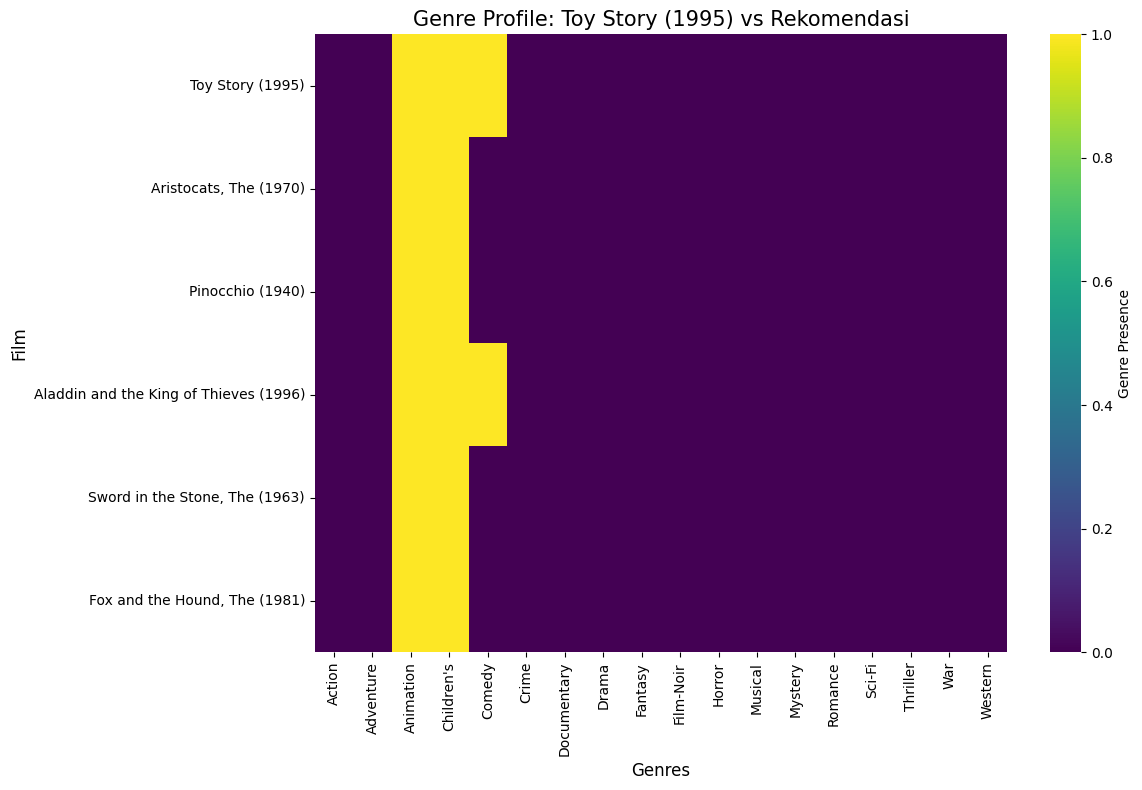

In [55]:
title = "Toy Story (1995)"
recommendation_result = recommend(title, k=10)
display_recommendations(recommendation_result, title)
visualize_recommendation(title, recommendation_result, content_data)

Insight Rekomendasi untuk "Toy Story (1995)"
Target Genre: Film ini termasuk genre Children's, Animation, dan Comedy. Sistem merekomendasikan film-film dengan genre serupa, yang menunjukkan model berhasil menangkap profil genre film target dengan tepat.

Precision@10 = 1.00: Artinya semua 10 film teratas yang direkomendasikan sangat relevan dengan genre film Toy Story. Ini menunjukkan performa yang sangat baik dalam hal kesesuaian genre.

Film-film direkomendasikan sebagian besar adalah film anak-anak klasik seperti Aladdin and the King of Thieves, The Aristocats, dan Pinocchio, yang juga memiliki elemen animasi dan cerita anak yang mirip.

Similarity Score tinggi (~0.937 - 1.000) menunjukkan bahwa model menggunakan fitur konten (genre) dengan sangat efektif untuk mengukur kemiripan antar film.

Rekomendasi ini akan membantu pengguna yang menyukai film keluarga dan animasi untuk menemukan film lain yang memiliki tema dan genre yang serupa, meningkatkan pengalaman pengguna dalam menemukan konten yang relevan dan menarik.

## Collaborative Filtering

#### Training Model SVD

In [62]:
# Inisialisasi dan latih model SVD
algo = SVD(n_epochs=20, n_factors=50, random_state=42)
print("Melatih model SVD...")
algo.fit(trainset)
print("Model SVD selesai dilatih.")


Melatih model SVD...
Model SVD selesai dilatih.


#### Fungsi Rekomendasi dengan Detail Film

In [63]:
def cf_recommend_with_details(algo, user_id, all_movie_ids, ratings_df, content_data, genre_columns, k=10):
    rated_movies = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].unique()
    movies_to_predict = [mid for mid in all_movie_ids if mid not in rated_movies]

    preds = [(mid, algo.predict(user_id, mid).est) for mid in movies_to_predict]
    preds.sort(key=lambda x: x[1], reverse=True)

    recommendations = []
    for movie_id, est_rating in preds[:k]:
        movie_row = content_data[content_data['movie_id'] == movie_id]
        title = movie_row.iloc[0]['movie_title'] if not movie_row.empty else "Unknown"
        genres = [g for g in genre_columns if not movie_row.empty and movie_row.iloc[0][g] == 1]
        main_genre = genres[0] if genres else "Unknown"

        recommendations.append({
            'movie_id': movie_id,
            'estimated_rating': round(est_rating, 4),
            'title': title,
            'main_genre': main_genre
        })

    return recommendations


#### Fungsi untuk Menampilkan Rekomendasi Top-N dalam Format Tabel

In [70]:
def display_top_n_recommendations(recommendations, user_id):
    if not recommendations:
        print(f"Tidak ada rekomendasi untuk user {user_id}.")
        return

    df = pd.DataFrame(recommendations)
    df.index = range(1, len(df) + 1)
    print(f"\nTop-{len(recommendations)} Rekomendasi Collaborative Filtering untuk User {user_id}:\n")
    print(df[['title', 'main_genre', 'estimated_rating']].to_string())


#### Visualisasi Rekomendasi CF

In [64]:
def visualize_cf_recommendation(user_id, recommendations, content_data, genre_columns, ratings_df):
    try:
        rated_movies = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].unique()
        watched = content_data[content_data['movie_id'].isin(rated_movies)].copy()

        rec_ids = [r['movie_id'] for r in recommendations[:5]]
        recs = content_data[content_data['movie_id'].isin(rec_ids)].copy()

        watched['type'] = 'Watched'
        recs['type'] = 'Recommended'

        combined = pd.concat([watched, recs])
        genre_profiles = combined.set_index(['movie_title', 'type'])[genre_columns]

        plt.figure(figsize=(12, 8))
        sns.heatmap(genre_profiles.astype(float), cmap='coolwarm', cbar_kws={'label': 'Genre Presence'})
        plt.title(f'Genre Profile: User {user_id} - Watched vs Recommended', fontsize=15)
        plt.xlabel('Genres', fontsize=12)
        plt.ylabel('Movies', fontsize=12)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error saat visualisasi: {e}")


### Testing


Top-10 Rekomendasi Collaborative Filtering untuk User 196:

                                                     title main_genre  estimated_rating
1                               Wrong Trousers, The (1993)  Animation            4.6135
2                         Shawshank Redemption, The (1994)      Drama            4.5700
3                                    Close Shave, A (1995)  Animation            4.5570
4                                  Schindler's List (1993)      Drama            4.5445
5                                        Casablanca (1942)      Drama            4.5216
6                                       Rear Window (1954)    Mystery            4.4628
7   Wallace & Gromit: The Best of Aardman Animation (1996)  Animation            4.4508
8                                      12 Angry Men (1957)      Drama            4.4472
9                               Usual Suspects, The (1995)      Crime            4.4402
10                               North by Northwest (1959) 

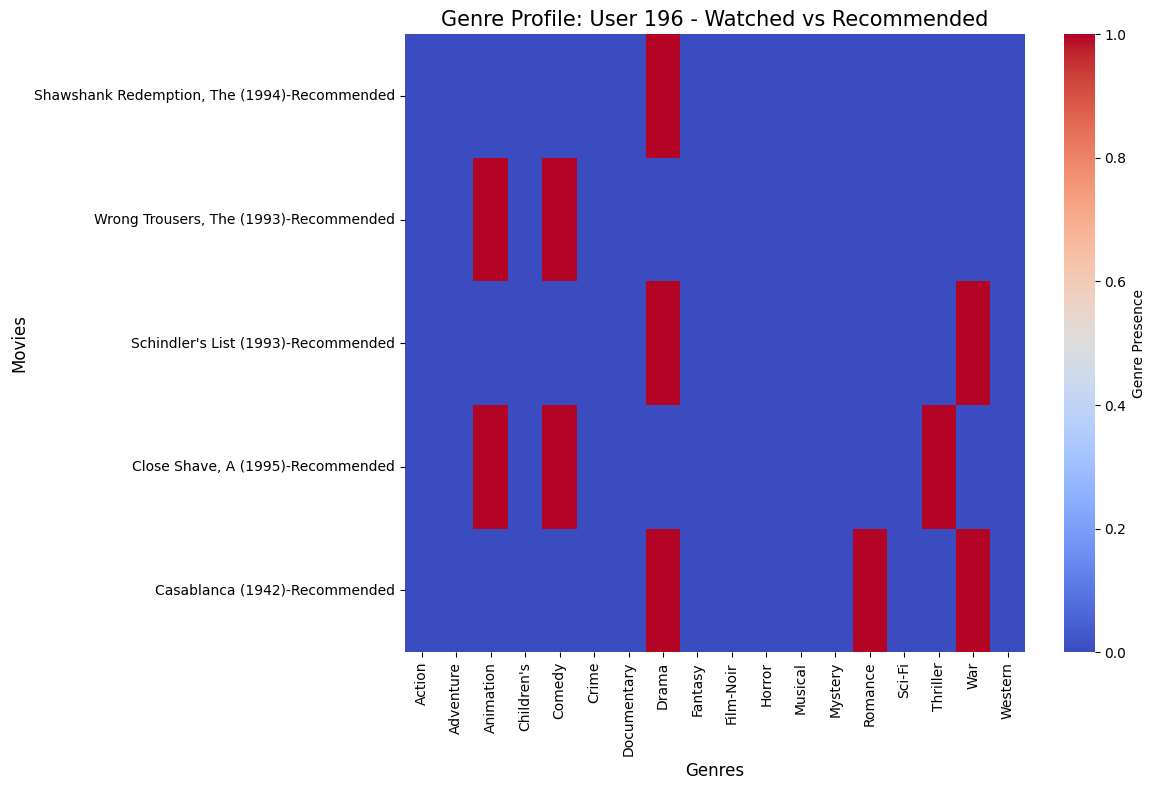

In [71]:
# ID user yang ingin direkomendasikan
user_id = '196'  # contoh user ID dari dataset

# Daftar seluruh movie_id unik dalam dataset
all_movie_ids = ratings_cf['movie_id'].unique()

# Dapatkan rekomendasi top-N untuk user
recommendations_cf = cf_recommend_with_details(
    algo=algo,
    user_id=user_id,
    all_movie_ids=all_movie_ids,
    ratings_df=ratings_cf,
    content_data=content_data,
    genre_columns=genre_columns,
    k=10  # jumlah rekomendasi yang diinginkan
)

# Tampilkan hasil rekomendasi dalam format tabel
display_top_n_recommendations(recommendations_cf, user_id)

# Visualisasikan perbandingan genre antara film yang sudah ditonton dan yang direkomendasikan
visualize_cf_recommendation(
    user_id=user_id,
    recommendations=recommendations_cf,
    content_data=content_data,
    genre_columns=genre_columns,
    ratings_df=ratings_cf
)


Insight Rekomendasi Collaborative Filtering untuk User 196
Variasi genre film yang direkomendasikan cukup beragam, mulai dari Animation, Drama, Mystery, Crime, hingga Comedy. Hal ini menunjukkan model mampu menangkap preferensi pengguna yang mungkin tidak hanya terpaku pada satu genre saja.

Estimasi rating tertinggi (~4.4 hingga 4.6) menunjukkan bahwa model memprediksi User 196 akan sangat menyukai film-film ini berdasarkan pola rating pengguna lain yang mirip.

Beberapa film rekomendasi seperti The Shawshank Redemption, Schindler's List, dan 12 Angry Men merupakan film klasik dan sangat populer, mengindikasikan bahwa pengguna mungkin menyukai film dengan kualitas tinggi dan cerita yang mendalam.

Rekomendasi animasi seperti Wrong Trousers, The dan Wallace & Gromit menunjukkan preferensi User 196 juga terhadap film animasi berkualitas, yang mungkin relevan dengan minat film anak-anak atau animasi stop-motion.

Model Collaborative Filtering memanfaatkan pola rating pengguna lain untuk memberikan rekomendasi personal, yang memungkinkan menemukan film-film berkualitas yang belum pernah ditonton oleh User 196 tapi berpotensi disukai.

Rekomendasi ini memberikan pengalaman yang dipersonalisasi dengan memperhitungkan interaksi pengguna secara langsung, sehingga lebih adaptif terhadap selera individual.

---


## Evaluation

Evaluasi performa kedua model dilakukan menggunakan metrik yang sesuai:

- **Content-Based Filtering:** Precision@K untuk mengukur relevansi rekomendasi berdasarkan genre.
- **Collaborative Filtering (SVD):** RMSE dan MAE untuk mengukur akurasi prediksi rating.

Hasil evaluasi akan digunakan untuk membandingkan kekuatan kedua pendekatan dan menentukan strategi terbaik untuk sistem rekomendasi.


### Content-Based Filtering

In [72]:
# Daftar film untuk evaluasi
sample_titles = [
    "Toy Story (1995)",
    "Star Wars (1977)",
    "Fargo (1996)",
    "Pulp Fiction (1994)",
    "Return of the Jedi (1983)"
]

precisions = []

print(f"\n[Evaluasi Content-Based Filtering - Precision@K]")
for title in sample_titles:
    result = recommend(title, k=10)
    precision = result['precision_at_k']
    print(f"{title} → Precision@10: {precision:.2f}")
    precisions.append(precision)

avg_precision = sum(precisions) / len(precisions)
print(f"\nRata-rata Precision@10: {avg_precision:.2f}")


[Evaluasi Content-Based Filtering - Precision@K]
Toy Story (1995) → Precision@10: 1.00
Star Wars (1977) → Precision@10: 1.00
Fargo (1996) → Precision@10: 1.00
Pulp Fiction (1994) → Precision@10: 1.00
Return of the Jedi (1983) → Precision@10: 1.00

Rata-rata Precision@10: 1.00


### Collaborative Filtering

In [73]:
# Evaluasi model SVD pada testset
predictions = algo.test(testset)

# Hitung metrik evaluasi
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"\n[Evaluasi Collaborative Filtering - SVD]")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

RMSE: 0.9336
MAE:  0.7378

[Evaluasi Collaborative Filtering - SVD]
RMSE: 0.9336
MAE : 0.7378


## 📊 Evaluasi Model

Evaluasi dilakukan untuk mengukur performa dua pendekatan sistem rekomendasi:

1. **Content-Based Filtering**
2. **Collaborative Filtering (SVD)**

### 🔹 Content-Based Filtering

Evaluasi menggunakan metrik **Precision@10**, yang mengukur proporsi item relevan dalam 10 rekomendasi teratas berdasarkan genre film.

| Judul Film              | Precision@10 |
|-------------------------|--------------|
| Toy Story (1995)        | 1.00         |
| Star Wars (1977)        | 1.00         |
| Fargo (1996)            | 1.00         |
| Pulp Fiction (1994)     | 1.00         |
| Return of the Jedi (1983) | 1.00       |

📌 **Rata-rata Precision@10: 1.00**

Hasil ini menunjukkan bahwa pendekatan Content-Based mampu memberikan rekomendasi yang sangat relevan secara konten (genre).

---

### 🔹 Collaborative Filtering (SVD)

Evaluasi menggunakan metrik berikut:

- **RMSE (Root Mean Squared Error)**: 0.9336  
- **MAE (Mean Absolute Error)**: 0.7378

Metrik ini digunakan untuk menilai akurasi prediksi rating model terhadap data uji. Nilai RMSE dan MAE yang cukup rendah menunjukkan bahwa prediksi model cukup dekat dengan rating aktual.

---

### Kesimpulan Evaluasi

- **Content-Based Filtering** sangat baik dalam menghasilkan rekomendasi relevan berdasarkan kemiripan konten.
- **Collaborative Filtering (SVD)** efektif dalam memprediksi rating pengguna dengan tingkat kesalahan yang dapat diterima.
- Kombinasi kedua pendekatan ini dapat saling melengkapi dan meningkatkan kualitas rekomendasi secara keseluruhan.
